# Processing of VASP NEB data to produce figures in the main manuscript
    
This notebook reads in data from from the `.csv` files in `open_data/data/for_plotting` and generates figures 4—10 in the manuscript &ldquo;Interfacial Strain Effects on Lithium Diffusion Pathways in the Spinel Solid Electrolyte Li-Doped MgAl<sub>2</sub>O<sub>4</sub>&rdquo;
  
    
## Required files:
```
open_data/
    ├── data/
    |   ├── for_plotting/
    |       ├── aniso_0.25.csv
    |       ├── aniso_0.50.csv
    |       ├── spinel_aniso_data.csv
    |       ├── spinel_iso_data.csv
    |       └── spinel_iso_pot_vol.csv
    ├── analysis/
        ├── pathway_figs/
            ├── 1_0.25.png
            ├── 1_0.5.png
            ├── 2_0.25.png
            ├── 2_0.5.png
            ├── 3R_0.25.png
            ├── 3R_0.5.png
            ├── 3_0.25.png
            └── 3_0.5.png
```

## Outputs:
- `neb_pathways_iso.pdf`
- `neb_pathways_aniso_025.pdf`
- `neb_pathways_aniso_050.pdf`
- `oct_vol_vs_delta_e_aniso.pdf`
- `oct_vol_vs_delta_e_iso.pdf`
- `pot_vs_delta_e.pdf`
- `strain_vs_barrier.pdf`

In [1]:
# external modules
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
from scipy.stats import linregress
from matplotlib.ticker import FormatStrFormatter
import matplotlib.pyplot as plt
import version_information

# local import
import figure_formatting as ff

%matplotlib inline
%config InlineBackend.figure_format='retina'

import warnings
warnings.filterwarnings('ignore')

In [2]:
# initialise default figure formatting
ff.set_rcParams( ff.master_formatting )

In [3]:
def pathway_label( strain, conc, pathway, aniso=False ):
    if aniso:
        label = r"$^\mathrm{{{}}}${}$_{{{:4.2f}}}^\mathrm{{{}}}$".format( 'A', strain, conc, pathway )
    else:
        label = r"{}$_{{{:4.2f}}}^\mathrm{{{}}}$".format( strain, conc, pathway )
    return label

In [4]:
pathway_dir = './pathway_figs/pngs'
figures_dir = '../figures'
data_dir = '../data/'

data_spinel = pd.read_csv( '{}/spinel_iso_data.csv'.format( data_dir ), delim_whitespace = True,comment='#')

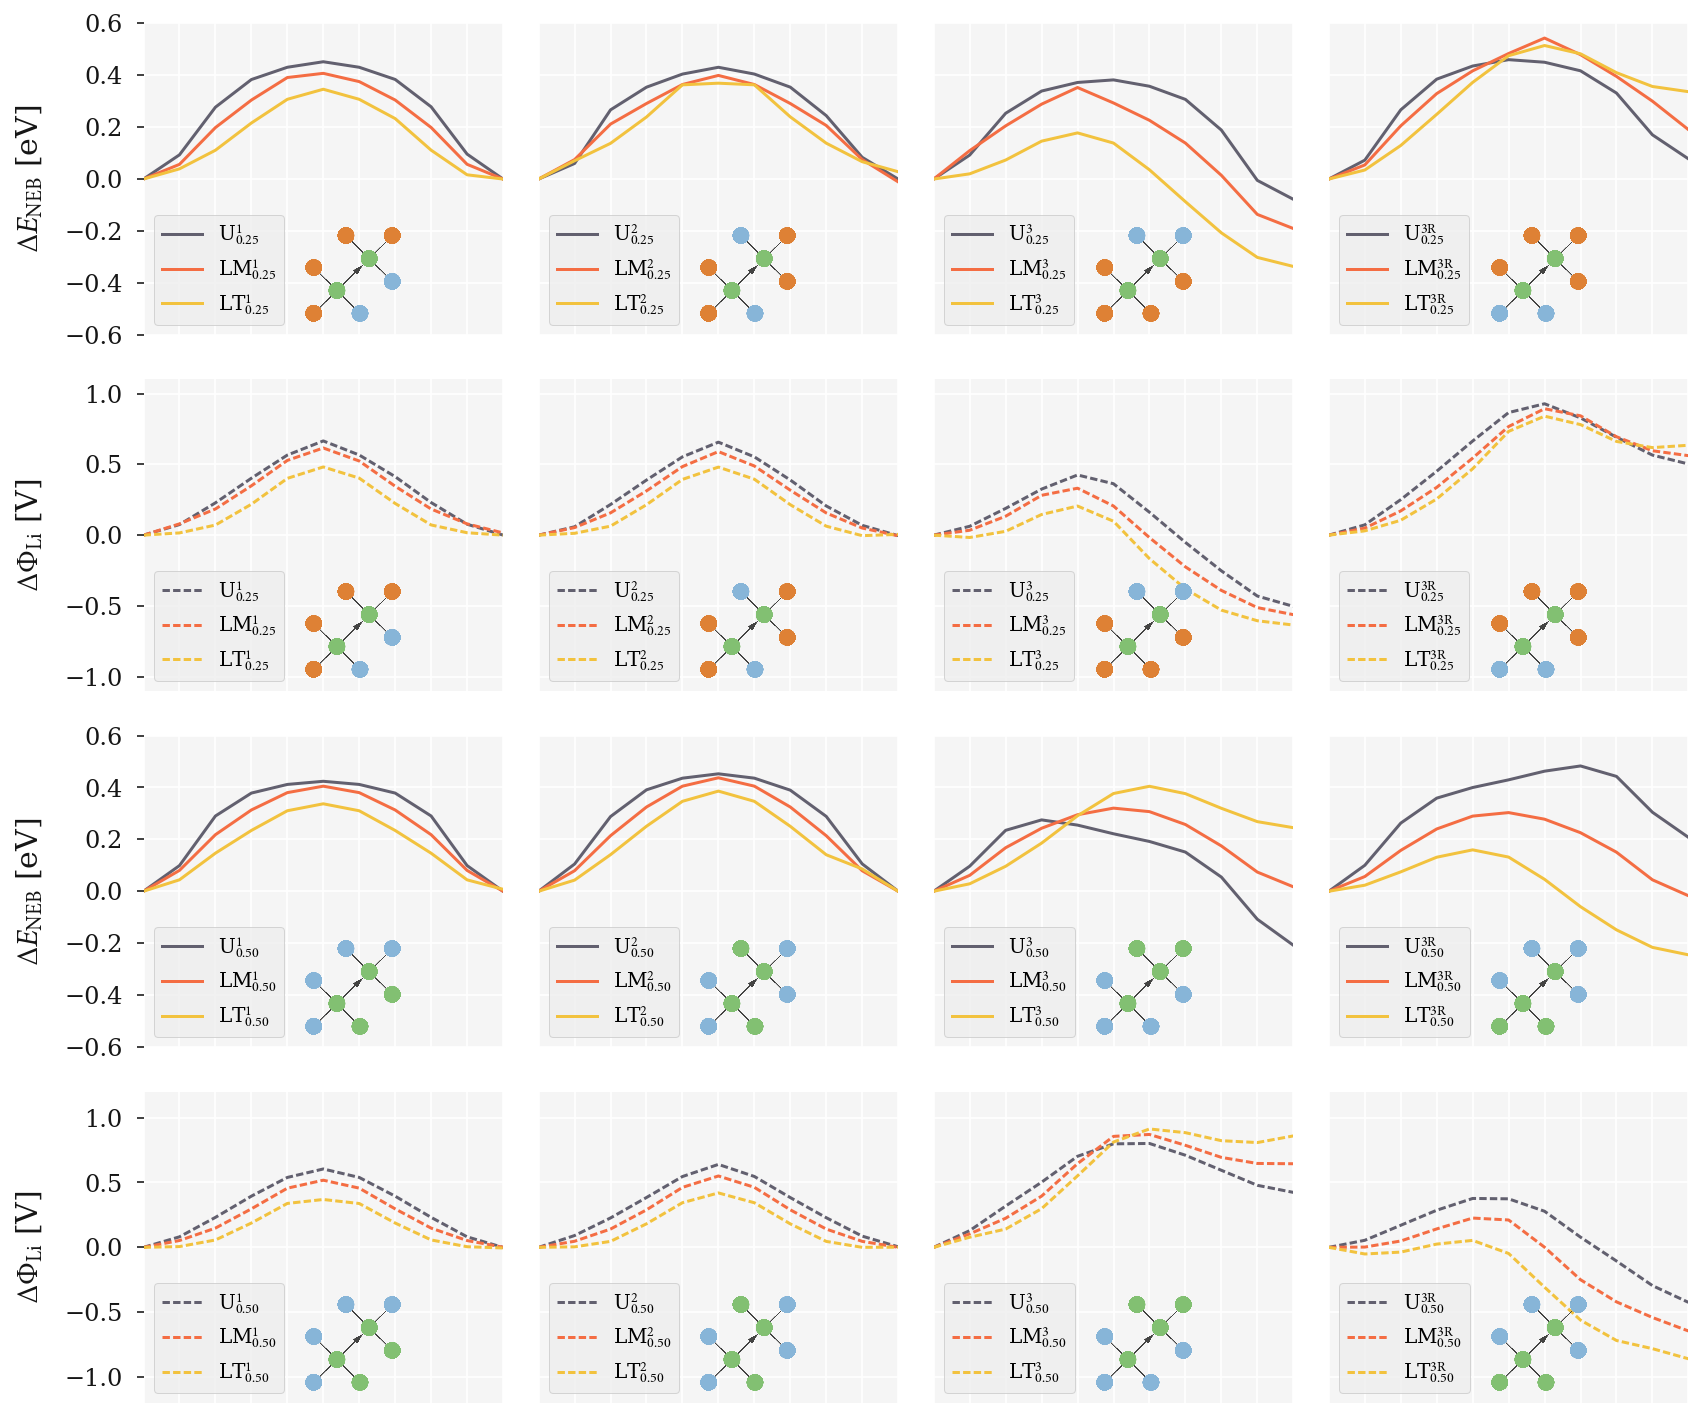

In [5]:
'''
   Produces Fig 4 in manuscript
'''

neb_params = { 'font.size': 10,
               'axes.labelsize': 15,
               'ytick.labelsize': 12 }
ff.set_rcParams( neb_params )

ncols=4
nrows=4

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize = (12, 10))

for i, path in enumerate( [ '1','2','3','3R'] ):
    for j,conc in enumerate ([0.25,0.50]):
                
        e_axis = axes[(j*2),i]
        p_axis = axes[(j*2)+1,i]

        if i==0:
            e_axis.set_ylabel(r'$\Delta E_\mathrm{NEB}$ [eV]')
            p_axis.set_ylabel(r'$\Delta\Phi_\mathrm{Li}$ [V]')
        if i>0:
            e_axis.set_yticklabels([])
            e_axis.tick_params( left='off' )
            p_axis.set_yticklabels([])
            p_axis.tick_params( left='off' )

        e_axis.set_xlim([0,10.0])        
        e_axis.set_ylim( ff.get_y_limits(1.2,0.5) )
        e_axis.set_yticks(np.arange(-0.6,+0.61,0.2))
        e_axis.set_xticks(np.arange(0,11,1))
        e_axis.set_xticklabels([])
        e_axis.tick_params( bottom='off' )
        
        p_axis.set_xlim([0,10.0]) 
        p_axis.set_ylim( ff.get_y_axis_limits(data_spinel.loc[ (data_spinel['conc']==conc)],'d_pot',0.5,1,0.15) )
        p_axis.set_xticks(np.arange(0,11,1))
        p_axis.set_xticklabels([])
        p_axis.tick_params( bottom='off' )

        for l, strain in enumerate(['U','LM','LT']):
            label=pathway_label( strain, conc, path )            
            x,y = ff.interpolate_df(data_spinel.loc[(data_spinel['path'] == path) 
                        & (data_spinel['conc'] == conc) 
                        & (data_spinel['strain'] == strain)]['delta_E'],[0,10],0.01)
            e_axis.plot(x, y, c=ff.colours[strain], label=label )
            e_axis.legend( loc='lower left' )           
            
            x,y = ff.interpolate_df(data_spinel.loc[(data_spinel['path'] == path) 
                        & (data_spinel['conc'] == conc) 
                        & (data_spinel['strain'] == strain)]['d_pot'],[0,10],0.01)
            p_axis.plot(x,y,c=ff.colours[strain],linestyle='dashed', label=label )
            p_axis.legend( loc='lower left' )

fig.tight_layout()

# Add pathway schematic png figures
xyz = ( 0.265, 0.45, 0.04 )
for i, e in enumerate( [ '1', '2', '3','3R'] ):
    for j, conc in enumerate (['0.25','0.50']):
        pot_index=(j*2)+1
        ene_index=(j*2)
        image_filename="{}/{}_{}.png".format(pathway_dir, e, conc)
        ff.place_image(fig, axes[ene_index,i], image_filename, *xyz )
        ff.place_image(fig, axes[pot_index,i], image_filename, *xyz )  
fig.savefig( '{}/neb_pathways_iso.pdf'.format( figures_dir ) )  

ff.set_rcParams( ff.master_formatting )

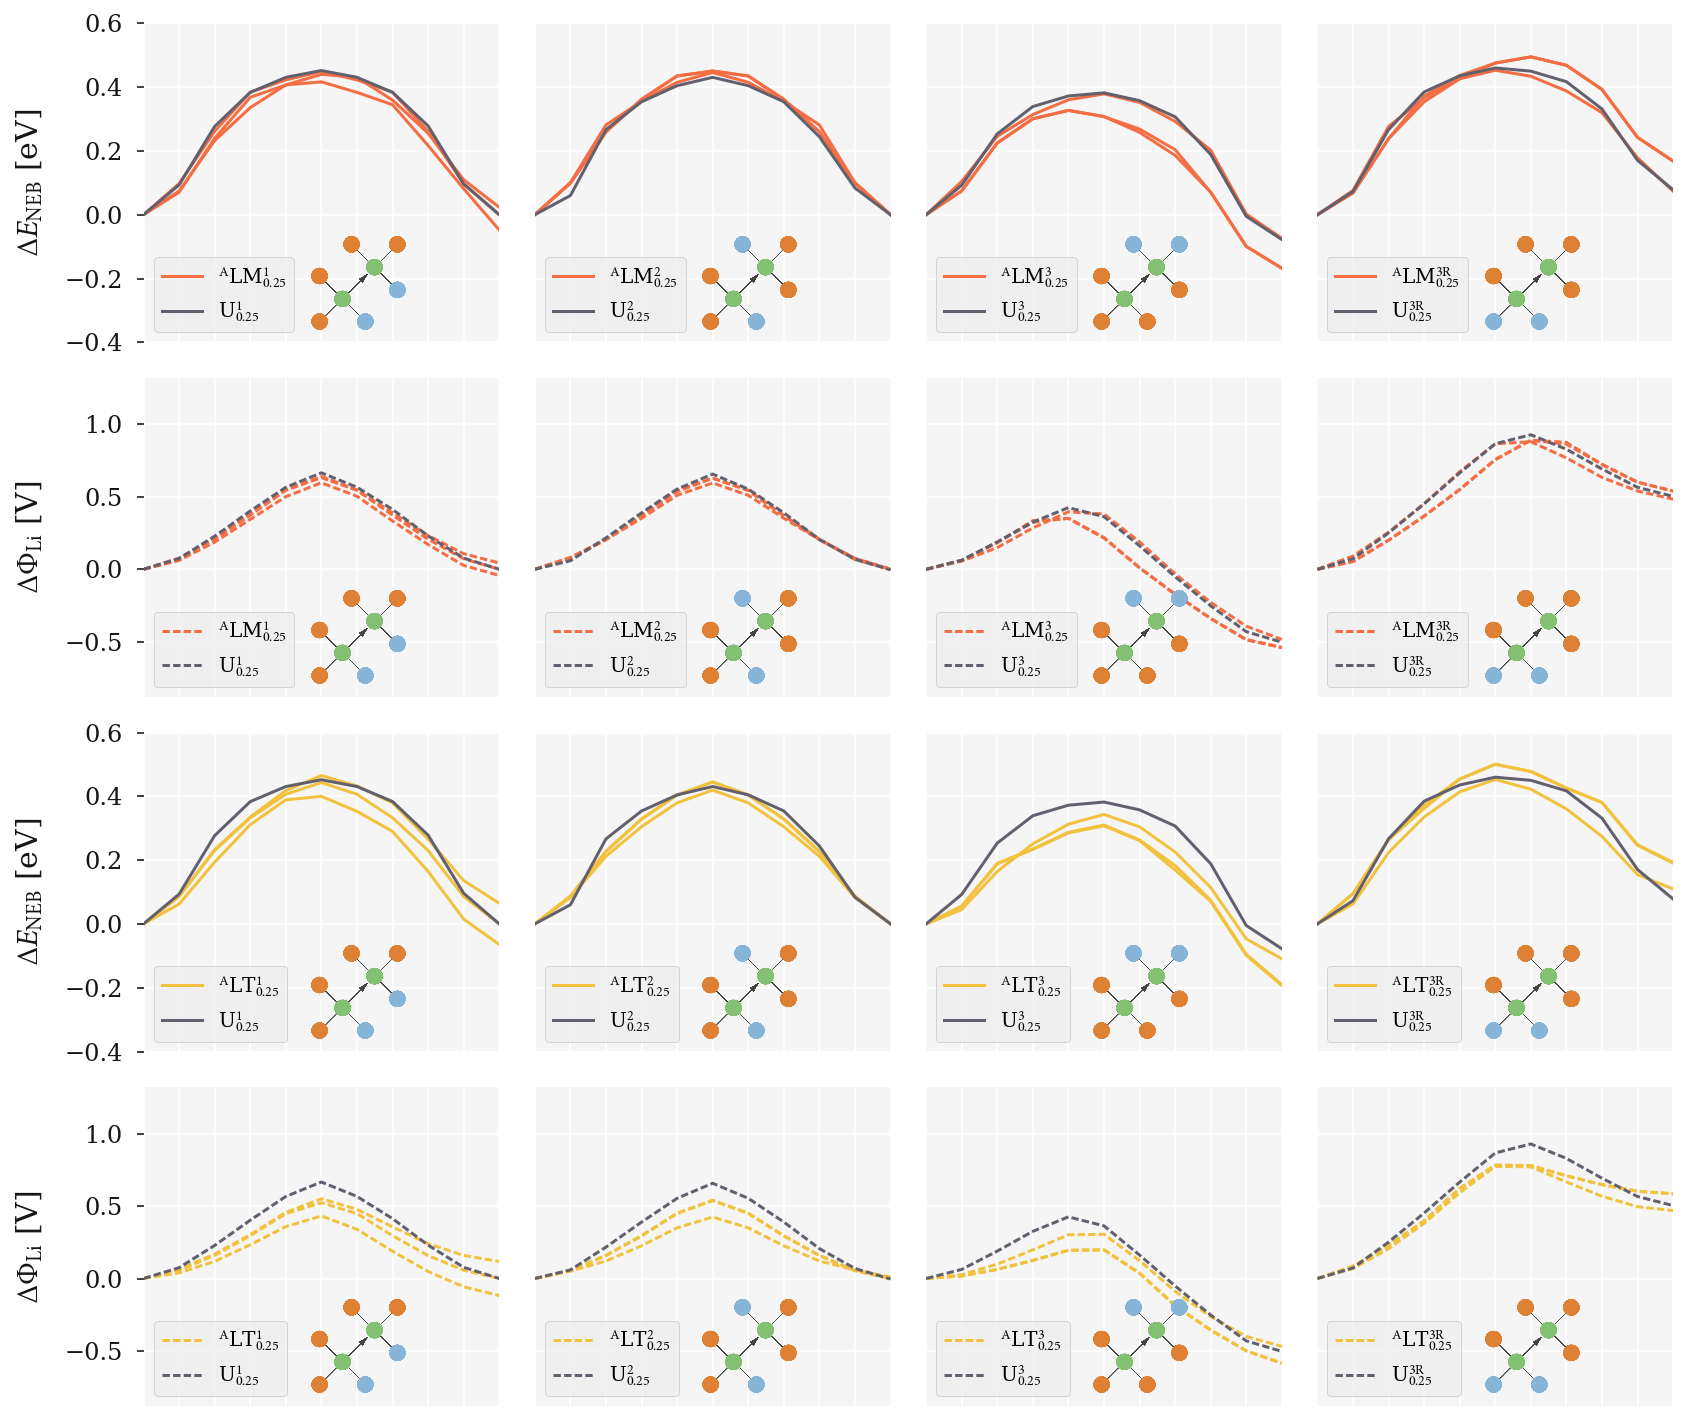

In [6]:
'''
   Produces Fig 7 in manuscript
'''
ff.set_rcParams( neb_params )

data_aniso_spinel = pd.read_csv( '{}/spinel_aniso_data.csv'.format( data_dir ), delim_whitespace=True, comment='#')

ncols = 4
nrows = 4

conc = 0.25

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize = (12, 10))

for i, path in enumerate( [ '1','2','3','3R'] ):
    for j,strain in enumerate (['LM','LT']):
        
        e_axis = axes[(j*2),i]
        p_axis = axes[(j*2)+1,i]
        
        for s in [ 'top', 'bottom', 'left', 'right' ]:
            e_axis.spines[s].set_visible( False )
            p_axis.spines[s].set_visible( False )

        if i==0:
            e_axis.set_ylabel(r'$\Delta E_\mathrm{NEB}$ [eV]')
            p_axis.set_ylabel(r'$\Delta\Phi_\mathrm{Li}$ [V]') 
        if i>0:
            e_axis.set_yticklabels([])
            e_axis.tick_params( left='off' )
            p_axis.set_yticklabels([])
            p_axis.tick_params( left='off' )
                 
        e_axis.set_xlim([0,10.0])        
        e_axis.set_ylim( ff.get_y_limits(1.0,0.4))
        e_axis.set_xticks(np.arange(0,11,1))
        e_axis.set_xticklabels([])
        e_axis.tick_params( bottom='off' )

        p_axis.set_xlim([0,10.0]) 
        p_axis.set_ylim(ff.get_y_axis_limits(data_spinel.loc[ (data_spinel['conc']==conc)],'d_pot',0.4,1,0.15))
        p_axis.set_xticks(np.arange(0,11,1))
        p_axis.set_xticklabels([])
        p_axis.tick_params( bottom='off' )
            
        for strain_axis in range(1,4):
                
            x,y = ff.interpolate_df(data_aniso_spinel.loc[(data_aniso_spinel['path'] == path) 
                            & (data_aniso_spinel['conc'] == conc) 
                            & (data_aniso_spinel['strain'] == strain)
                            & (data_aniso_spinel['axes'] == strain_axis)]['delta_E'],[0,10],0.01)
            if strain_axis == 1:
                label = pathway_label( strain, conc, path, aniso=True )
            else:
                label = None
                     
            e_axis.plot(x,y,c=ff.colours[strain],label=label)
            
            x,y = ff.interpolate_df(data_aniso_spinel.loc[(data_aniso_spinel['path'] == path) 
                        & (data_aniso_spinel['conc'] == conc) 
                        & (data_aniso_spinel['strain'] == strain)
                        & (data_aniso_spinel['axes'] == strain_axis)]['d_pot'], [0,10], 0.01 )
            p_axis.plot(x,y,c=ff.colours[strain],linestyle='dashed', label=label)
            
        col=ff.colours['U']     
        x,y = ff.interpolate_df(data_spinel.loc[(data_spinel['path'] == path) 
                             & (data_spinel['conc'] == conc) 
                             & (data_spinel['strain'] == 'U')]['delta_E'],[0,10],0.01)
        e_axis.plot( x, y, c=col, label=pathway_label( 'U', conc, path ) )
        e_axis.legend(loc='lower left')
        
        x,y = ff.interpolate_df(data_spinel.loc[(data_spinel['path'] == path) 
                             & (data_spinel['conc'] == conc) 
                          & (data_spinel['strain'] == 'U')]['d_pot'], [0,10], 0.01 )
        p_axis.plot(x,y,c=col,linestyle='dashed', label=pathway_label( 'U', conc, path ) )         
        p_axis.legend(loc='lower left')
                        
fig.tight_layout()        

# Add pathway schematic png figures
xyz = ( 0.265, 0.47, 0.04 )
for j, strain in enumerate (['LM','LT']):
    for i, path in enumerate(['1','2','3','3R']):        
        pot_index=(j*2)+1
        ene_index=(j*2)
        image_filename="{}/{}_{:4.2f}.png".format(pathway_dir, path, conc)
        ff.place_image( fig, axes[pot_index,i], image_filename, *xyz )
        ff.place_image( fig, axes[ene_index,i], image_filename, *xyz )
fig.savefig( '{}/neb_pathways_aniso_025.pdf'.format( figures_dir ) )    

ff.set_rcParams( ff.master_formatting )

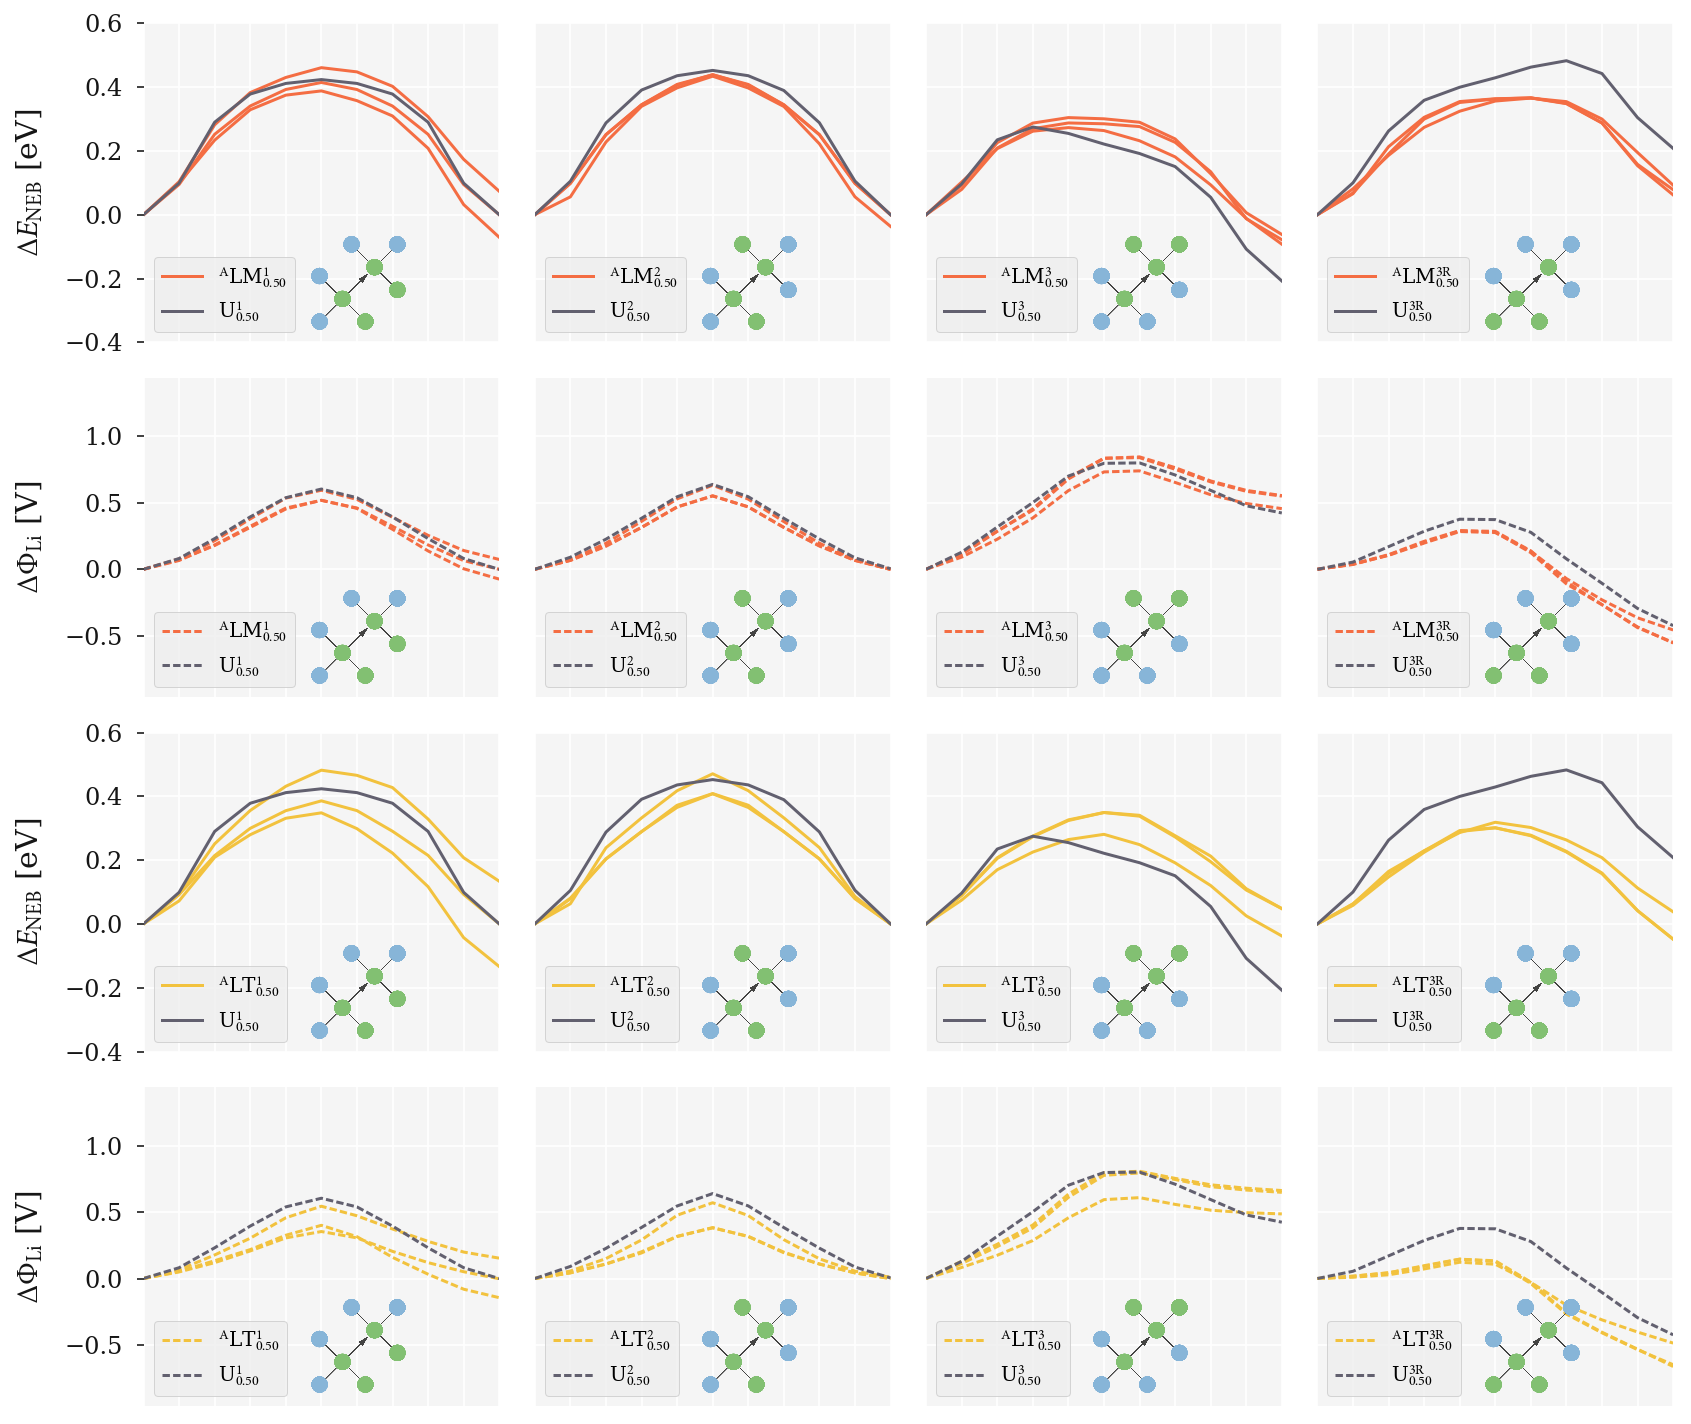

In [7]:
'''
   Produces Fig 8 in manuscript
'''
ff.set_rcParams( neb_params )

data_aniso_spinel = pd.read_csv( '{}/spinel_aniso_data.csv'.format( data_dir ), delim_whitespace=True, comment='#')

ncols = 4
nrows = 4

conc = 0.50

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize = (12, 10))

for i, path in enumerate( [ '1','2','3','3R'] ):
    for j,strain in enumerate (['LM','LT']):
        
        e_axis = axes[(j*2),i]
        p_axis = axes[(j*2)+1,i]
        
        for s in [ 'top', 'bottom', 'left', 'right' ]:
            e_axis.spines[s].set_visible( False )
            p_axis.spines[s].set_visible( False )

        if i==0:
            e_axis.set_ylabel(r'$\Delta E_\mathrm{NEB}$ [eV]')
            p_axis.set_ylabel(r'$\Delta\Phi_\mathrm{Li}$ [V]') 
        if i>0:
            e_axis.set_yticklabels([])
            e_axis.tick_params( left='off' )
            p_axis.set_yticklabels([])
            p_axis.tick_params( left='off' )
                 
        e_axis.set_xlim([0,10.0])        
        e_axis.set_ylim( ff.get_y_limits(1.0,0.4))
        e_axis.set_xticks(np.arange(0,11,1))
        e_axis.set_xticklabels([])
        e_axis.tick_params( bottom='off' )

        p_axis.set_xlim([0,10.0]) 
        p_axis.set_ylim(ff.get_y_axis_limits(data_spinel.loc[ (data_spinel['conc']==conc)],'d_pot',0.4,1,0.15))
        p_axis.set_xticks(np.arange(0,11,1))
        p_axis.set_xticklabels([])
        p_axis.tick_params( bottom='off' )
            
        for strain_axis in range(1,4):
                
            x,y = ff.interpolate_df(data_aniso_spinel.loc[(data_aniso_spinel['path'] == path) 
                            & (data_aniso_spinel['conc'] == conc) 
                            & (data_aniso_spinel['strain'] == strain)
                            & (data_aniso_spinel['axes'] == strain_axis)]['delta_E'],[0,10],0.01)
            if strain_axis == 1:
                label = pathway_label( strain, conc, path, aniso=True )
            else:
                label = None
                     
            e_axis.plot(x,y,c=ff.colours[strain],label=label)
            
            x,y = ff.interpolate_df(data_aniso_spinel.loc[(data_aniso_spinel['path'] == path) 
                        & (data_aniso_spinel['conc'] == conc) 
                        & (data_aniso_spinel['strain'] == strain)
                        & (data_aniso_spinel['axes'] == strain_axis)]['d_pot'], [0,10], 0.01 )
            p_axis.plot(x,y,c=ff.colours[strain],linestyle='dashed', label=label)
            
        col=ff.colours['U']     
        x,y = ff.interpolate_df(data_spinel.loc[(data_spinel['path'] == path) 
                             & (data_spinel['conc'] == conc) 
                             & (data_spinel['strain'] == 'U')]['delta_E'],[0,10],0.01)
        e_axis.plot( x, y, c=col, label=pathway_label( 'U', conc, path ) )
        e_axis.legend(loc='lower left')
        
        x,y = ff.interpolate_df(data_spinel.loc[(data_spinel['path'] == path) 
                             & (data_spinel['conc'] == conc) 
                          & (data_spinel['strain'] == 'U')]['d_pot'], [0,10], 0.01 )
        p_axis.plot(x,y,c=col,linestyle='dashed', label=pathway_label( 'U', conc, path ) )         
        p_axis.legend(loc='lower left')
                        
fig.tight_layout()        

# Add pathway schematic png figures
xyz = ( 0.265, 0.47, 0.04 )
for j, strain in enumerate (['LM','LT']):
    for i, path in enumerate(['1','2','3','3R']):        
        pot_index=(j*2)+1
        ene_index=(j*2)
        image_filename="{}/{}_{:4.2f}.png".format(pathway_dir, path, conc)
        ff.place_image( fig, axes[pot_index,i], image_filename, *xyz )
        ff.place_image( fig, axes[ene_index,i], image_filename, *xyz )
fig.savefig( '{}/neb_pathways_aniso_050.pdf'.format( figures_dir ) )    

ff.set_rcParams( ff.master_formatting )

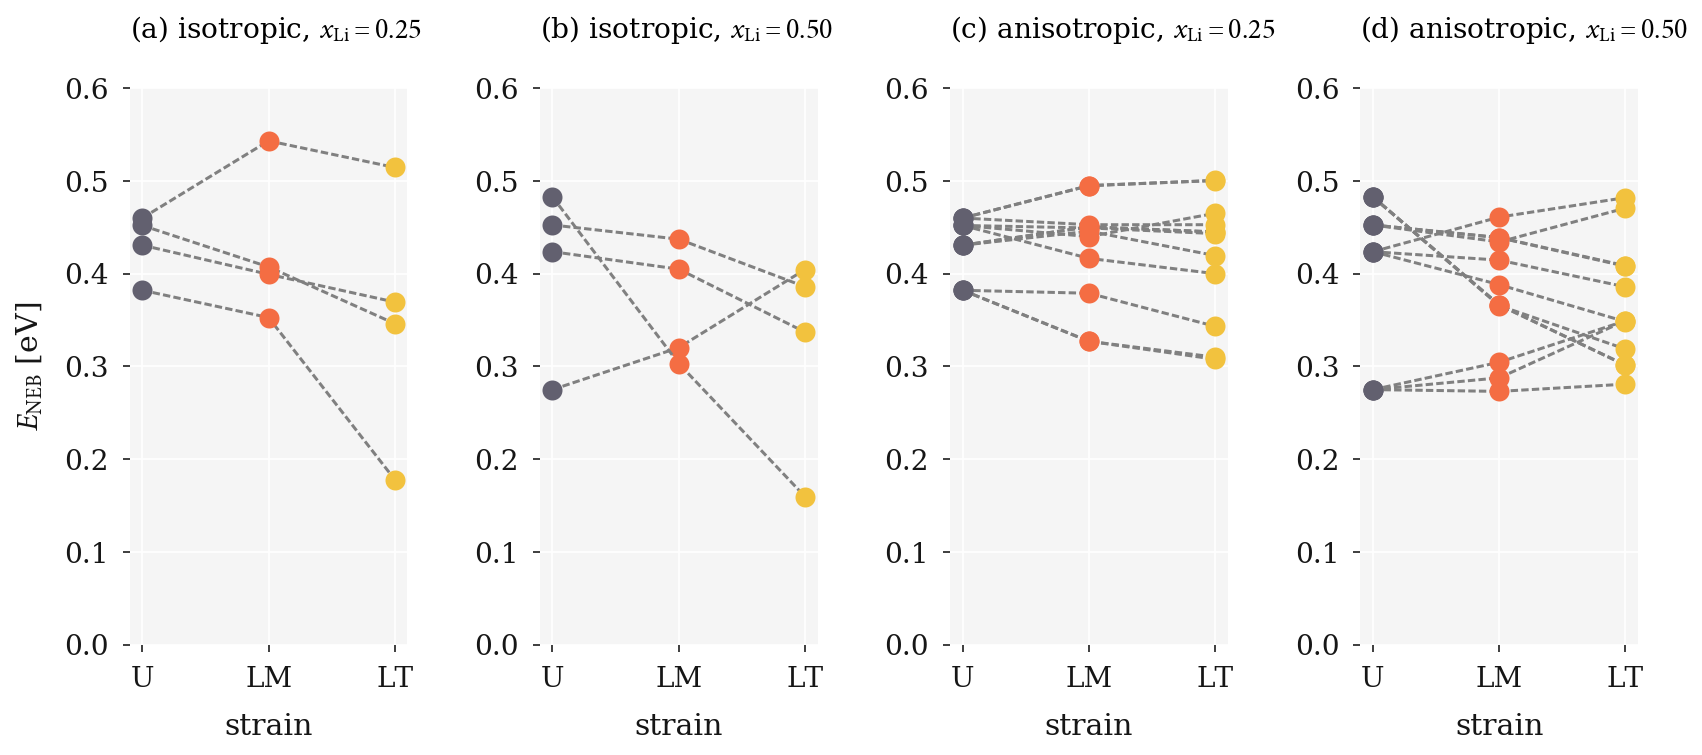

In [8]:
fontsize = 14

scatter_formatting ={ 'font.size': fontsize,
                      'axes.labelsize': fontsize+1,
                      'xtick.labelsize': fontsize,
                      'ytick.labelsize': fontsize,
                      'lines.markersize': 10.0 }

ff.set_rcParams( scatter_formatting )

fig, ax = plt.subplots(nrows=1, ncols=4, figsize = (12.0, 5.5))
title = [ r'(a) isotropic, $x_\mathrm{Li}=0.25$', 
          r'(b) isotropic, $x_\mathrm{Li}=0.50$',
          r'(c) anisotropic, $x_\mathrm{Li}=0.25$', 
          r'(d) anisotropic, $x_\mathrm{Li}=0.50$',]

for i, x in enumerate( [0.25, 0.50] ):
    for path in [ '1', '2', '3', '3R' ]:
        loc = ( data_spinel.path == path ) & ( data_spinel.strain == 'U') & ( data_spinel.conc == x )
        barriers = [ max( data_spinel[loc].delta_E ) ]
        for strain in [ 'LM', 'LT' ]:
            loc = ( ( data_spinel.path == path ) & 
                    ( data_spinel.strain == strain) & 
                    ( data_spinel.conc == x ) )
            barriers.append( max( data_spinel[loc].delta_E ) )
        ax[i].plot( barriers, '-', c='grey', linestyle='dashed' )
        for j, ( b, strain ) in enumerate( zip( barriers, [ 'U', 'LM', 'LT' ] ) ): 
            ax[i].plot( j, b, 'o', c=ff.colours[strain] )
    
for i, x in enumerate( [0.25, 0.50], 2 ):
    for path in [ '1', '2', '3', '3R' ]:
        for axes in [1,2,3]:
            loc = ( data_spinel.path == path ) & ( data_spinel.strain == 'U') & ( data_spinel.conc == x )
            barriers = [ max( data_spinel[loc].delta_E ) ]
            for strain in [ 'LM', 'LT' ]:
                loc = ( ( data_aniso_spinel.path == path ) & 
                        ( data_aniso_spinel.strain == strain) & 
                        ( data_aniso_spinel.conc == x ) & 
                        ( data_aniso_spinel['axes'] == axes ) )
                barriers.append( max( data_aniso_spinel[loc].delta_E ) )
            ax[i].plot( barriers, '-', c='grey', linestyle='dashed' )
            for j, ( b, strain ) in enumerate( zip( barriers, [ 'U', 'LM', 'LT' ] ) ): 
                ax[i].plot( j, b, 'o', c=ff.colours[strain] )

for i in range(len(title)):
    ax[i].set_ylim([0,0.6])
    ax[i].set_title( title[i], fontsize=fontsize, loc='left') 
    ax[i].set_xticks( (0,1,2) )
    ax[i].set_xticklabels( ( 'U', 'LM', 'LT' ) )
    ax[i].set_xlabel( 'strain' )
    
ax[0].set_ylabel( r'$E_\mathrm{NEB}$ [eV]')

plt.tight_layout()
fig.savefig( '{}/strain_vs_barrier_height.pdf'.format( figures_dir ) )

ff.set_rcParams( ff.master_formatting )

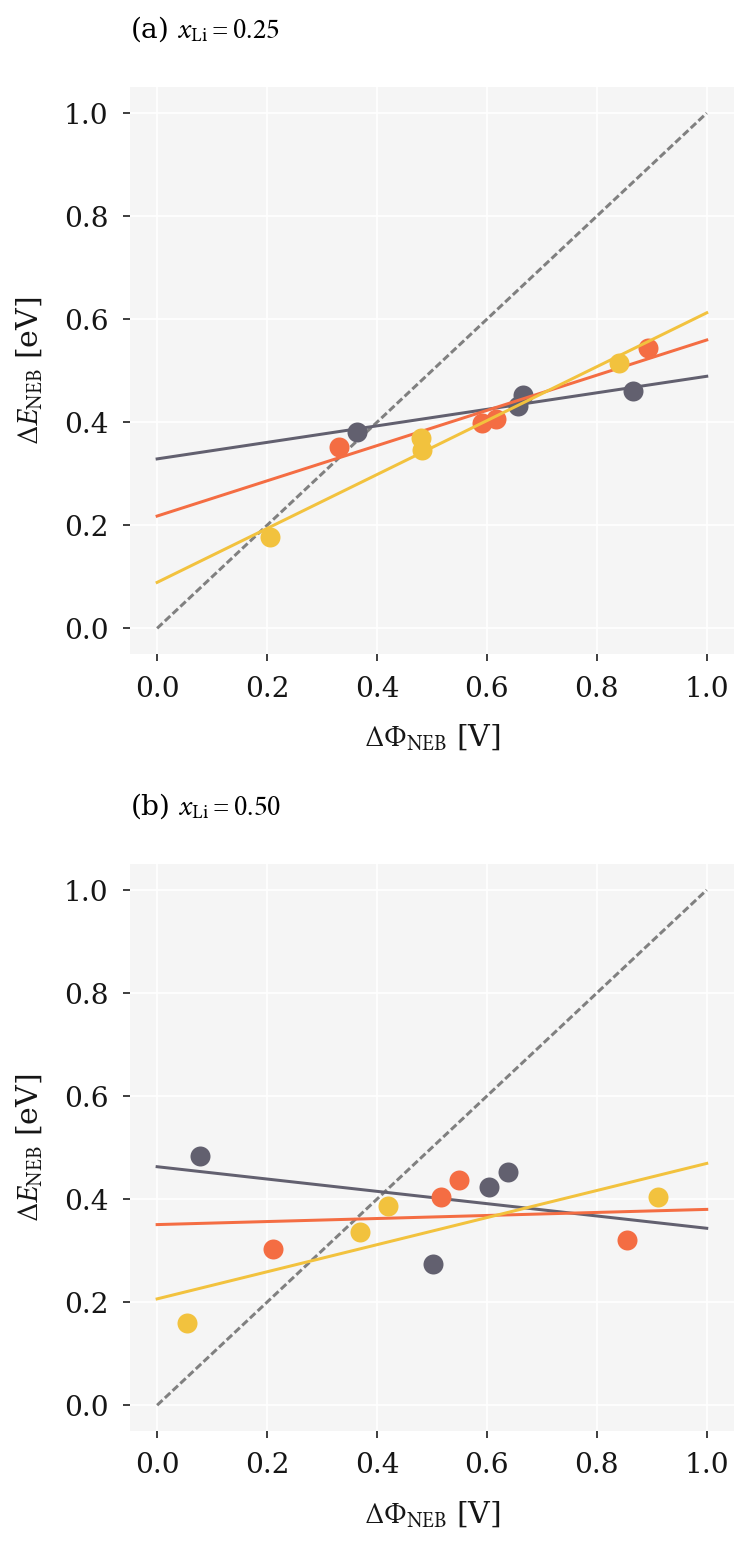

In [9]:
'''
Produces Fig 6
'''
df = pd.read_csv( '{}/spinel_iso_data.csv'.format( data_dir ), delim_whitespace=True, comment='#')

ff.set_rcParams( scatter_formatting )
      
fig, axes = plt.subplots(nrows=2, ncols=1, figsize = (5.5, 11))
fit_range = np.array( [ 0.0, 1.0 ] )

for ax, conc in zip( axes, [ 0.25, 0.5 ] ):
    ax.plot( fit_range, fit_range, '--', color='grey' )
    
    ax.set_xlabel( r'$\Delta\Phi_\mathrm{NEB}$ [V]' )
    ax.set_ylabel( r'$\Delta E_\mathrm{NEB}$ [eV]' )
    ax.xaxis.set_major_locator(ticker.MultipleLocator(0.2))
    
    for strain in [ 'U', 'LM', 'LT' ]:        
        
        x=[]
        y=[]
    
        for path in [ '1', '2', '3', '3R' ]:    

            loc = ( df.path == path ) & ( df.conc == conc ) & ( df.strain == strain )
            max_ind = df[loc].delta_E.idxmax()
            
            E_bar = df['delta_E'].values[max_ind]
            p_bar = df['d_pot'].values[max_ind]
            
            x.append( p_bar )
            y.append( E_bar )
            
            ax.plot( p_bar, E_bar, 'o', linestyle='None',c=ff.colours[strain], clip_on=False )
            
        slope, intercept, rvalue, pvalue, stderr = linregress( x, y )
        ax.plot( np.array( [ 0.0, 1.0 ] ), ff.line( np.array( [ 0.0, 1.0 ] ), slope, intercept ), c=ff.colours[strain] )

axes[0].set_title( r'(a) $x_\mathrm{Li}=0.25$', fontsize=fontsize, loc='left') 
axes[1].set_title( r'(b) $x_\mathrm{Li}=0.50$', fontsize=fontsize, loc='left')   

fig.tight_layout() 
fig.savefig( '{}/pot_vs_delta_e.pdf'.format( figures_dir ) )

ff.set_rcParams( ff.master_formatting )

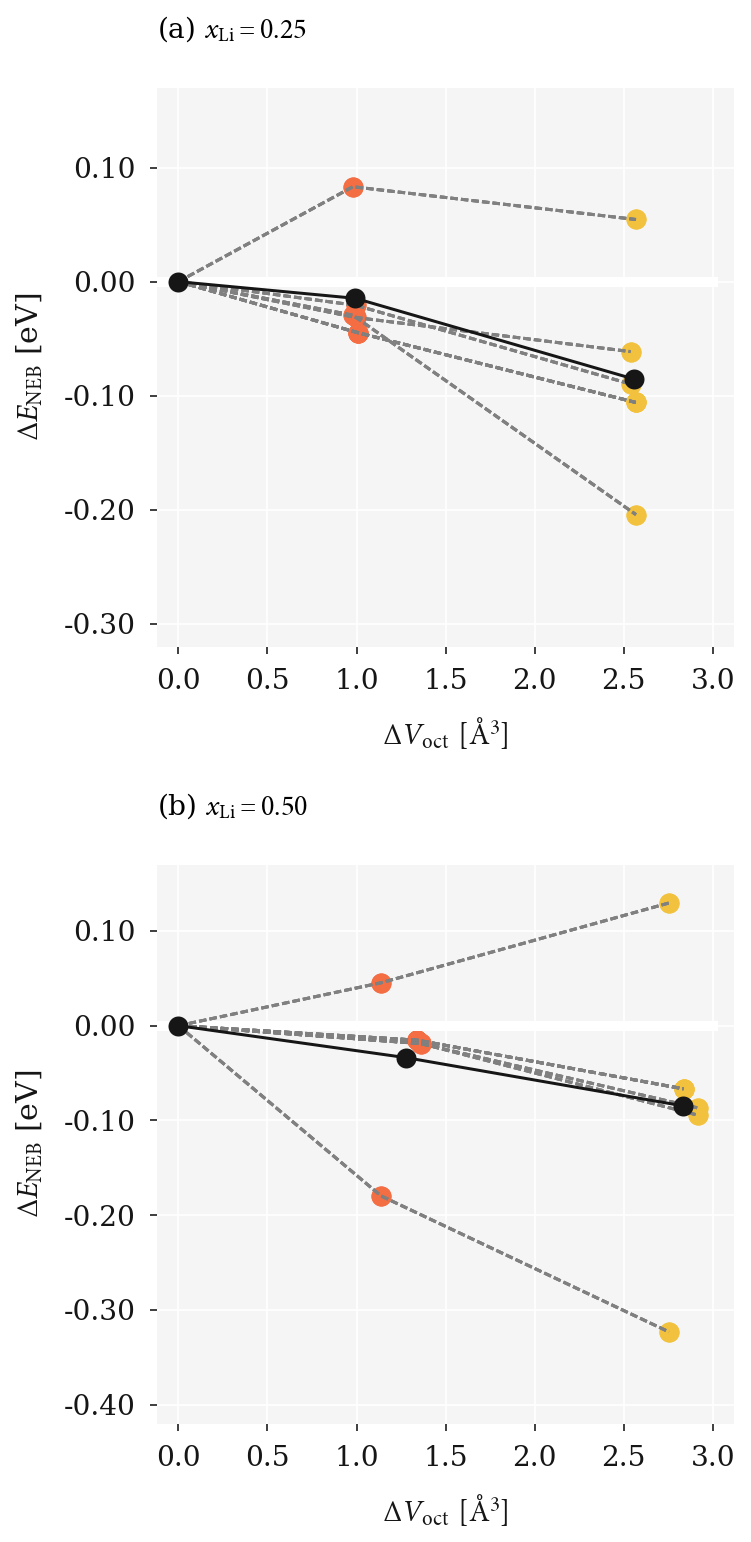

In [10]:
'''
Figure 5
'''

ff.set_rcParams( scatter_formatting )

fig, axes = plt.subplots(nrows=2, ncols=1, figsize = (5.5, 11))
title = [ r'(a) $x_\mathrm{Li}=0.25$', r'(b) $x_\mathrm{Li}=0.50$' ]

df = pd.read_csv( '{}/spinel_iso_pot_vol.csv'.format( data_dir, conc ), delim_whitespace=True, comment='#' )

for i, conc in enumerate( [ 0.25, 0.50 ] ):
    
    x=np.array( [ -0.2, 3.0 ] )
    y=np.array( [ 0.0, 0.0 ] )
    
    axes[i].plot(x,y,c='white', linewidth=5)

    axes[i].set_xlabel( r'$\Delta V_\mathrm{oct}$ $[\mathrm{\AA}^3]$' )
    axes[i].set_ylabel( r'$\Delta E_\mathrm{NEB}$ [eV]' )

    axes[i].set_xlim([0.0,3.0])
    axes[i].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

    for path in ['1', '2', '3','1R','2R','3R']:
        for ax in range(1,4):
            x=[]
            y=[]
            x.append(0.000)
            y.append(0.000)
        
            for strain in ['LM','LT']: 
                loc = ( df.path == path ) & ( df.conc == conc ) & ( df.strain == strain )
                x.append( df[ loc ].dPolyV.values[0] )
                y.append( df[ loc ].dEbar.values[0] )
            axes[i].plot( x, y, c='grey', linestyle='dashed' )
       
    x=[]
    y=[]
    x.append(0.000)
    y.append(0.000)

    for strain in (['LM','LT']):
        loc = ( df.conc == conc ) & ( df.strain == strain )
        x.append( df[ loc ].dPolyV.mean() )
        y.append( df[ loc ].dEbar.mean() )
 
    axes[i].plot(x,y,'co',c=ff.nearly_black, linestyle='solid',label='average', clip_on=False, zorder=2 )
    
    lm_lab = False
    lt_lab = False
    label = None
    
    for ax in range(1,4):
        for path in (['1','1R','2','2R','3','3R']):
            for j,strain in enumerate(['LM','LT']):
                col = ff.colours[ strain ]
                if strain =='LT':
                    if lt_lab == True:
                        label = None
                    else:    
                        label = r"LiTi$_5$O$_{12}$"
                        lt_lab = True
                
                if strain == 'LM':
                    if lm_lab == True:
                        label = None
                    else:    
                        label = r"LiMn$_2$O$_4$"
                        lm_lab = True
                          
                x=[]
                y=[]
                loc = ( df.path == path ) & ( df.conc == conc ) & ( df.strain == strain )
                x.append( df[ loc ].dPolyV.values[0] )
                y.append( df[ loc ].dEbar.values[0] )       
     
                axes[i].plot(x,y,'ro', c=col, label=label, alpha=0.8, zorder=1 )       

    axes[i].set_title( title[i], fontsize=fontsize, loc='left') 
    
axes[0].set_ylim([-0.32,0.17])
axes[1].set_ylim([-0.42,0.17])
axes[0].set_xlim([-0.12,3.12])
axes[1].set_xlim([-0.12,3.12])
axes[0].set_xticks(np.linspace(0.0,3.0,7))
axes[1].set_xticks(np.linspace(0.0,3.0,7))

plt.tight_layout()
plt.savefig( '{}/oct_vol_vs_delta_e_iso.pdf'.format( figures_dir, conc ) )
    
ff.set_rcParams( ff.master_formatting )

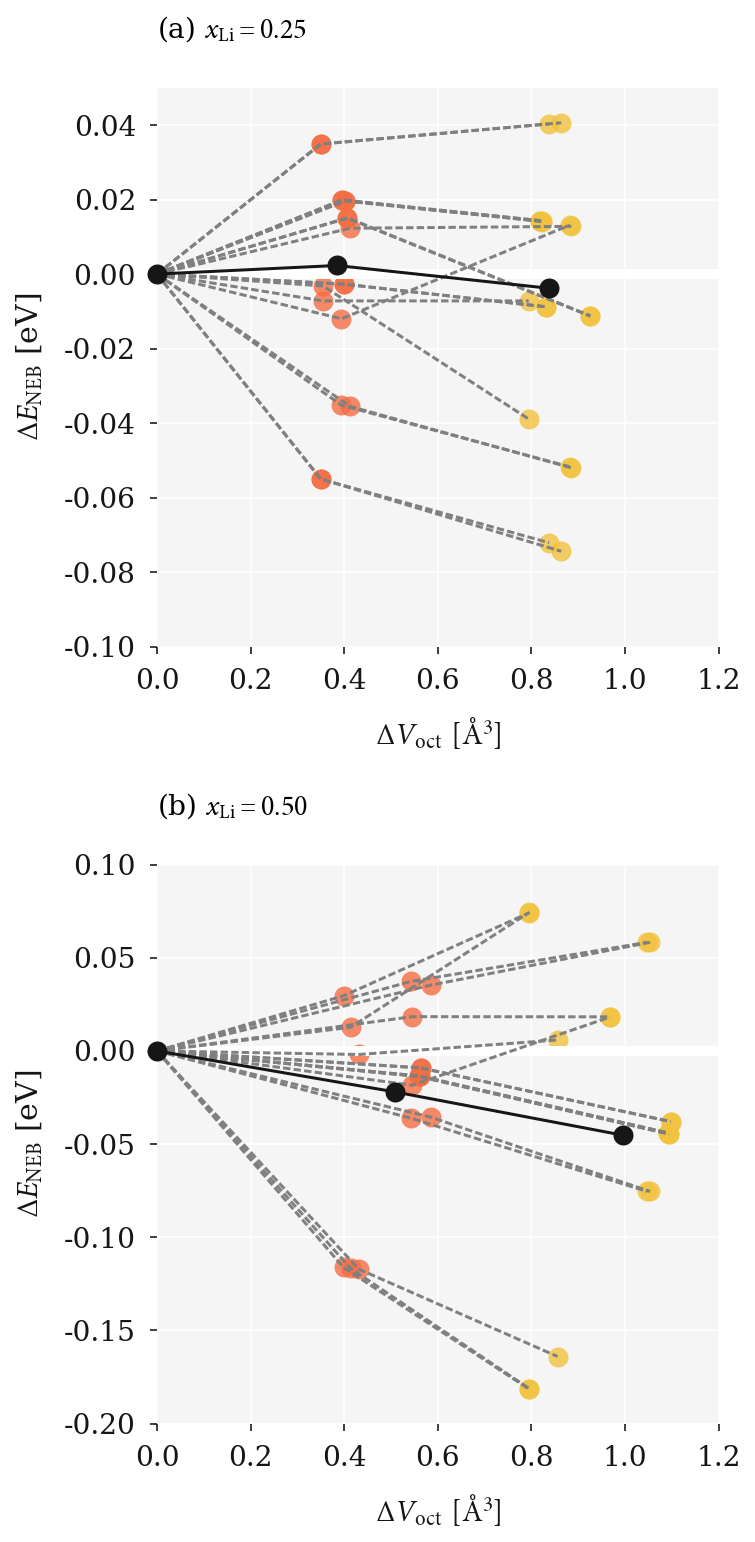

In [11]:
'''
Figure 9
'''

ff.set_rcParams( scatter_formatting )

fig, axes = plt.subplots(nrows=2, ncols=1, figsize = (5.5, 11))
title = [ r'(a) $x_\mathrm{Li}=0.25$', r'(b) $x_\mathrm{Li}=0.50$' ]

for i, conc in enumerate( [ 0.25, 0.50 ] ):
    
    x=np.array( [ -0.2, 1.2 ] )
    y=np.array( [ 0.0, 0.0 ] )
    
    axes[i].plot(x,y,c='white', linewidth=5)
    
    df = pd.read_csv( '{}/aniso_{:2.2f}.csv'.format( data_dir, conc ), delim_whitespace=True, comment='#' )

    axes[i].set_xlabel( '$\Delta V_\mathrm{oct}$ $[\mathrm{\AA}^3]$' )
    axes[i].set_ylabel( r'$\Delta E_\mathrm{NEB}$ [eV]' )

    axes[i].set_xlim([0.0,1.2])
    axes[i].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

    for path in ['1', '2', '3','1R','2R','3R']:
        for ax in range(1,4):
            x=[]
            y=[]
            x.append(0.000)
            y.append(0.000)
        
            for strain in ['LM','LT']:
                loc = ( df.path == path ) & ( df['axes'] == ax ) & ( df.conc == conc ) & ( df.strain == strain )
                x.append( df[ loc ].dPolyV.values[0] )
                y.append( df[ loc ].dEbar.values[0] )          
            axes[i].plot(x,y,c='grey',linestyle='dashed')
       
    x=[]
    y=[]
    x.append(0.000)
    y.append(0.000)

    for strain in (['LM','LT']):
        loc = ( df['axes'] == ax ) & ( df.conc == conc ) & ( df.strain == strain )
        x.append( df[ loc ].dPolyV.mean() )
        y.append( df[ loc ].dEbar.mean() ) 
    axes[i].plot(x,y,'co',c=ff.nearly_black, linestyle='solid',label='average', clip_on=False, zorder=2 )
    
    lm_lab = False
    lt_lab = False
    label = None
    
    for ax in range(1,4):
        for path in (['1','1R','2','2R','3','3R']):
            for j,strain in enumerate(['LM','LT']):
                col = ff.colours[ strain ]
                if strain =='LT':
                    if lt_lab == True:
                        label = None
                    else:    
                        label = r"LiTi$_5$O$_{12}$"
                        lt_lab = True
                
                if strain == 'LM':
                    if lm_lab == True:
                        label = None
                    else:    
                        label = r"LiMn$_2$O$_4$"
                        lm_lab = True
                          
                x=[]
                y=[]
                loc = ( df.path == path ) & ( df['axes'] == ax ) & ( df.conc == conc ) & ( df.strain == strain )
                x.append( df[ loc ].dPolyV.values[0] )
                y.append( df[ loc ].dEbar.values[0] )       
                axes[i].plot(x,y,'ro', c=col, label=label, alpha=0.8, zorder=1 )       

    axes[i].set_title( title[i], fontsize=fontsize, loc='left') 
    
axes[0].set_ylim([-0.10,0.05])
axes[1].set_ylim([-0.20,0.10])

plt.tight_layout()
plt.savefig( '{}/oct_vol_vs_delta_e_aniso.pdf'.format( figures_dir, conc ) )
    
ff.set_rcParams( ff.master_formatting )

In [12]:
%load_ext version_information
%version_information pandas, numpy, matplotlib, scipy, version_information 

Software versions
Python 3.6.1 64bit [GCC 4.2.1 Compatible Apple LLVM 8.1.0 (clang-802.0.42)]
IPython 6.2.1
OS Darwin 17.4.0 x86_64 i386 64bit
pandas 0.21.1
numpy 1.13.3
matplotlib 2.1.1
scipy 1.0.0
version_information 1.0.3
Sun Feb 11 10:57:29 2018 GMT